AMV Historical Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the data
df = pd.read_csv('AMV Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,"3,700.0","3,600.0","3,800.0","3,600.0",1.44M,2.78%
1,05/30/2024,"3,600.0","3,600.0","3,800.0","3,500.0",3.23M,2.86%
2,05/29/2024,"3,500.0","3,500.0","3,600.0","3,500.0",522.68K,0.00%
3,05/28/2024,"3,500.0","3,500.0","3,600.0","3,500.0",452.54K,0.00%
4,05/27/2024,"3,500.0","3,500.0","3,600.0","3,500.0",660.47K,0.00%
5,05/24/2024,"3,500.0","3,600.0","3,600.0","3,400.0",2.27M,-2.78%
6,05/23/2024,"3,600.0","3,500.0","3,700.0","3,500.0",1.49M,2.86%
7,05/22/2024,"3,500.0","3,500.0","3,600.0","3,500.0",947.98K,0.00%
8,05/21/2024,"3,500.0","3,400.0","3,600.0","3,400.0",1.52M,2.94%
9,05/20/2024,"3,400.0","3,500.0","3,600.0","3,400.0",1.66M,-2.86%


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [4]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,15225.0,15270.0,15315.0,15180.0,4.70K,-0.29%
2019-03-04,14865.0,15180.0,15180.0,14865.0,19.01K,-2.36%
2019-03-05,14414.0,14865.0,15045.0,14414.0,48.80K,-3.03%
2019-03-06,14594.0,14414.0,14684.0,14414.0,17.25K,1.25%
2019-03-07,14144.0,14594.0,14594.0,14144.0,28.81K,-3.08%
...,...,...,...,...,...,...
2024-05-27,3500.0,3500.0,3600.0,3500.0,660.47K,0.00%
2024-05-28,3500.0,3500.0,3600.0,3500.0,452.54K,0.00%
2024-05-29,3500.0,3500.0,3600.0,3500.0,522.68K,0.00%


In [5]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [7]:
# Split data into training and testing sets
train_size = int(0.8 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [8]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [9]:
# Create training and testing datasets
time_step = 100
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, ytest = create_dataset(test_features, test_target, time_step)

In [10]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [11]:
# Build and train RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0537 - val_loss: 0.0030
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031 - val_loss: 4.7742e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021 - val_loss: 4.4129e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020 - val_loss: 3.1258e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 5.4238e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023 - val_loss: 6.2312e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 2.8842e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 2.7206e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018 - val_loss: 5.3655e-04


In [12]:
# Extract features from RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [13]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_rnn, label=y_train)
test_data_lgb = lgb.Dataset(test_features_rnn, label=ytest, reference=train_data_lgb)

In [14]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,  # Decreased learning rate for better accuracy
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,  # Allow trees to grow deep
    'num_boost_round': 200  # Increased number of boosting rounds
}

In [15]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 949, number of used features: 1
[LightGBM] [Info] Start training from score 0.444503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [16]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_rnn, num_iteration=lgb_model.best_iteration)

In [17]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [18]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
msle = mean_squared_log_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)

In [19]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Root Mean Squared Error (RMSE): 0.05434922588848398
Mean Absolute Percentage Error (MAPE): 128.702837120585%
Mean Squared Logarithmic Error (MSLE): 0.00256410881111504
Mean Squared Error (MSE): 0.002953838354677458
Mean Absolute Error (MAE): 0.054018968252548955


In [20]:
# Prepare initial data for predicting next 30 days
initial_data = scaled_features[-time_step:].reshape(1, time_step, scaled_features.shape[1])

In [21]:
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []

    for _ in range(30):
        # Predict features using RNN
        rnn_features = rnn_model.predict(initial_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        initial_data = np.roll(initial_data, -1, axis=1)
        initial_data[:, -1, -1] = next_close[0]

    return predictions

In [22]:
# Predict next 30 days
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

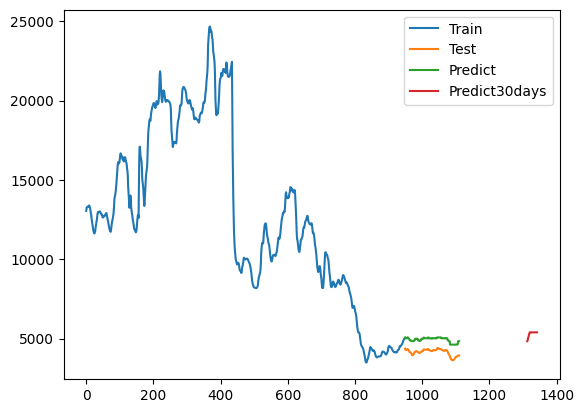

In [23]:
# Plotting train data
train_data_index = pd.RangeIndex(start=0, stop=len(train_features_rnn), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

# Plotting test data
test_data_index = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(test_features_rnn), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=len(df), stop=len(df) + len(next_30_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()

DHT Historical Data

In [24]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt

In [25]:
# Load and preprocess the data
df = pd.read_csv('DHT Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,"40,400.0","39,300.0","41,000.0","38,900.0",154.53K,2.80%
1,05/30/2024,"39,300.0","38,800.0","39,800.0","38,500.0",76.57K,-0.51%
2,05/29/2024,"39,500.0","39,900.0","39,900.0","38,300.0",107.35K,0.51%
3,05/28/2024,"39,300.0","38,600.0","39,500.0","38,200.0",61.63K,1.81%
4,05/27/2024,"38,600.0","35,200.0","39,900.0","35,200.0",133.26K,6.04%
5,05/24/2024,"36,400.0","36,600.0","36,900.0","35,500.0",101.02K,-0.55%
6,05/23/2024,"36,600.0","36,400.0","36,600.0","35,200.0",169.40K,1.95%
7,05/22/2024,"35,900.0","36,600.0","36,900.0","35,600.0",284.82K,-1.91%
8,05/21/2024,"36,600.0","36,500.0","36,800.0","35,100.0",295.50K,2.81%
9,05/20/2024,"35,600.0","34,600.0","36,000.0","34,300.0",246.31K,2.89%


In [26]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [27]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,10860.1,10916.2,11224.9,10663.6,138.72K,1.84%
2019-03-04,11224.9,11056.5,11477.4,11056.5,296.00K,3.36%
2019-03-05,11337.1,11224.9,11365.2,10888.1,308.00K,1.00%
2019-03-06,11561.6,11309.1,11589.7,11309.1,292.91K,1.98%
2019-03-07,11589.7,11842.2,11842.2,11224.9,240.15K,0.24%
...,...,...,...,...,...,...
2024-05-27,38600.0,35200.0,39900.0,35200.0,133.26K,6.04%
2024-05-28,39300.0,38600.0,39500.0,38200.0,61.63K,1.81%
2024-05-29,39500.0,39900.0,39900.0,38300.0,107.35K,0.51%


In [28]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [29]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [30]:
# Split data into training and testing sets
train_size = int(0.8 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [31]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [33]:
# Create training and testing datasets
time_step = 100
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, ytest = create_dataset(test_features, test_target, time_step)

In [34]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [35]:
# Build and train RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0093 - val_loss: 0.0012
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7617e-04 - val_loss: 1.5441e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7285e-04 - val_loss: 1.7636e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3808e-04 - val_loss: 1.0420e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7790e-04 - val_loss: 1.0097e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9271e-04 - val_loss: 9.7105e-05
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9952e-04 - val_loss: 9.5625e-05
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5756e-04 - val_loss: 9.2208e-05
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0798e-04 - val_loss: 1.0683e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9753e-04 - val_loss: 9.1092e-05


In [36]:
# Extract features from RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [37]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_rnn, label=y_train)
test_data_lgb = lgb.Dataset(test_features_rnn, label=ytest, reference=train_data_lgb)

In [38]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,  # Decreased learning rate for better accuracy
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,  # Allow trees to grow deep
    'num_boost_round': 200  # Increased number of boosting rounds
}

In [39]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 948, number of used features: 1
[LightGBM] [Info] Start training from score 0.202685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [40]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_rnn, num_iteration=lgb_model.best_iteration)

In [41]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [42]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
msle = mean_squared_log_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)

In [43]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Root Mean Squared Error (RMSE): 0.264921458940992
Mean Absolute Percentage Error (MAPE): 40.9474972265041%
Mean Squared Logarithmic Error (MSLE): 0.03236257030426771
Mean Squared Error (MSE): 0.07018337940742372
Mean Absolute Error (MAE): 0.22950698679740808


In [44]:
# Prepare initial data for predicting next 30 days
initial_data = scaled_features[-time_step:].reshape(1, time_step, scaled_features.shape[1])

In [45]:
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []

    for _ in range(30):
        # Predict features using RNN
        rnn_features = rnn_model.predict(initial_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        initial_data = np.roll(initial_data, -1, axis=1)
        initial_data[:, -1, -1] = next_close[0]

    return predictions

In [46]:
# Predict next 30 days
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

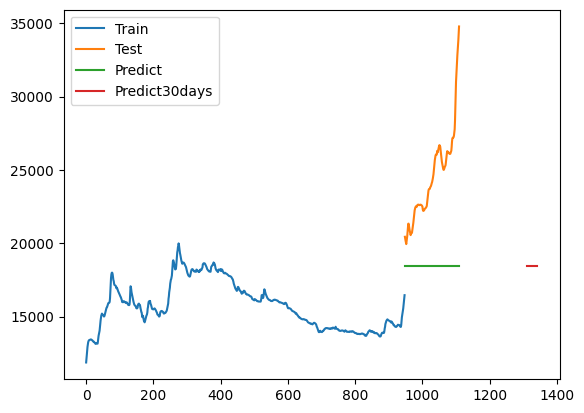

In [47]:
# Plotting train data
train_data_index = pd.RangeIndex(start=0, stop=len(train_features_rnn), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

# Plotting test data
test_data_index = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(test_features_rnn), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=len(df), stop=len(df) + len(next_30_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()

DP3 Historical Data

In [48]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt

In [49]:
# Load and preprocess the data
df = pd.read_csv('DP3 Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,"61,600","61,500","61,700","61,500",10.51K,0.16%
1,05/30/2024,"61,500","61,000","61,500","60,700",5.11K,0.82%
2,05/29/2024,"61,000","62,000","62,000","61,000",7.30K,0.00%
3,05/28/2024,"61,000","61,000","61,800","60,900",7.90K,0.16%
4,05/27/2024,"60,900","61,700","61,700","60,900",12.67K,-0.16%
5,05/24/2024,"61,000","62,400","62,400","61,000",22.64K,-2.24%
6,05/23/2024,"62,400","62,500","62,500","62,000",10.81K,-0.16%
7,05/22/2024,"62,500","61,700","62,500","61,600",18.32K,1.30%
8,05/21/2024,"61,700","62,000","62,000","61,700",15.51K,-0.32%
9,05/20/2024,"61,900","62,000","62,000","61,600",6.11K,-0.16%


In [50]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [51]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,73800,73000,73900,73000,1.54K,0.54%
2019-03-04,74900,73800,75200,73800,8.34K,1.49%
2019-03-05,74400,75000,75000,74000,7.33K,-0.67%
2019-03-06,74700,74100,75000,74000,3.81K,0.40%
2019-03-07,76300,75000,76900,74700,11.57K,2.14%
...,...,...,...,...,...,...
2024-05-27,60900,61700,61700,60900,12.67K,-0.16%
2024-05-28,61000,61000,61800,60900,7.90K,0.16%
2024-05-29,61000,62000,62000,61000,7.30K,0.00%


In [52]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [53]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [54]:
# Split data into training and testing sets
train_size = int(0.8 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [55]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [56]:
# Create training and testing datasets
time_step = 100
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, ytest = create_dataset(test_features, test_target, time_step)

In [57]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [58]:
# Build and train RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1429 - val_loss: 0.0023
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0076 - val_loss: 9.0359e-04
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - val_loss: 3.5282e-04
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 3.3698e-04
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - val_loss: 2.9209e-04
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021 - val_loss: 3.0805e-04
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 3.4237e-04
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024 - val_loss: 2.9390e-04
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - val_loss: 2.9429e-04
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018 - val_loss: 2.9089e-04


In [59]:
# Extract features from RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [60]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_rnn, label=y_train)
test_data_lgb = lgb.Dataset(test_features_rnn, label=ytest, reference=train_data_lgb)

In [61]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,  # Decreased learning rate for better accuracy
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,  # Allow trees to grow deep
    'num_boost_round': 200  # Increased number of boosting rounds
}

In [62]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 808, number of used features: 1
[LightGBM] [Info] Start training from score 0.390847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [63]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_rnn, num_iteration=lgb_model.best_iteration)

In [64]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [65]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
msle = mean_squared_log_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)


In [66]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.01959887411119683
Mean Absolute Percentage Error (MAPE): 12.875821165331416%
Mean Squared Logarithmic Error (MSLE): 0.00023005183886705115
Mean Squared Error (MSE): 0.00038411586642654133
Mean Absolute Error (MAE): 0.01700540529694633


In [67]:
# Prepare initial data for predicting next 30 days
initial_data = scaled_features[-time_step:].reshape(1, time_step, scaled_features.shape[1])

In [68]:
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []

    for _ in range(30):
        # Predict features using RNN
        rnn_features = rnn_model.predict(initial_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        initial_data = np.roll(initial_data, -1, axis=1)
        initial_data[:, -1, -1] = next_close[0]

    return predictions

In [69]:
# Predict next 30 days
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

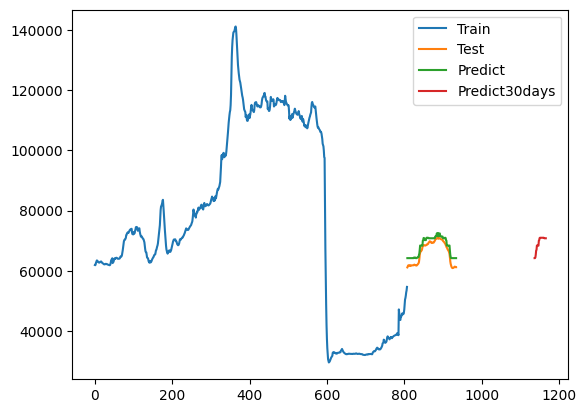

In [70]:
# Plotting train data
train_data_index = pd.RangeIndex(start=0, stop=len(train_features_rnn), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

# Plotting test data
test_data_index = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(test_features_rnn), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=len(df), stop=len(df) + len(next_30_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()